A Dockerfile that will produce a container with all the dependencies necessary to run this notebook is available [here](https://github.com/AustinRochford/notebooks).

In [1]:
%matplotlib inline

In [2]:
from warnings import filterwarnings

In [3]:
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

In [4]:
# configure pyplot for readability when rendered as a slideshow and projected
plt.rc('figure', figsize=(8, 6))

LABELSIZE = 14
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=LABELSIZE)
plt.rc('figure', titlesize=LABELSIZE)
plt.rc('legend', fontsize=LABELSIZE)
plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

plt.rc('animation', writer='avconv')

In [5]:
filterwarnings('ignore', 'findfont')

In [6]:
blue, green, red, purple, gold, teal = sns.color_palette()

pct_formatter = StrMethodFormatter('{x:.1%}')

In [7]:
SEED = 54902 # from random.org, for reproducibility

np.random.seed(SEED)

# Open Source Bayesian Inference in Python with PyMC3

<center><img src='https://raw.githubusercontent.com/pymc-devs/pymc3/master/docs/pymc3_logo.jpg'></center>


## FOSSCON &#8226; Philadelphia &#8226; August 26, 2017

## [@AustinRochford](https://twitter.com/AustinRochford)

## Who am I?

<center><img src='http://austinrochford.com/resources/img/face_big.png' width=400></center>

### [@AustinRochford](https://twitter.com/AustinRochford) &#8226; [arochford@monetate.com](mailto:arochford@monetate.com)

### PyMC3 developer &#8226; Principal Data Scientist at [Monetate Labs](http://www.monetate.com/)

## Bayesian Inference

A motivating question:

> A rare disease is present in one out of one hundred thousand people.  A test gives the correct diagnosis 99.9% of the time.  What is the probability that a person that tests positive has the disease?

### Conditional Probability

[_Conditional probability_](https://en.wikipedia.org/wiki/Conditional_probability) is the probability that one event will happen, given that another event has occured.

$$
\begin{align*}
P(A\ |\ B)
    & = \textrm{the probability that } A \textrm{ will happen if we know that } B \textrm{ has happened} \\
    & = \frac{P(A \textrm{ and } B)}{P(B)}.
\end{align*}
$$

Our question,

> A rare disease is present in one out of one hundred thousand people.  A test gives the correct diagnosis 99.9% of the time.  What is the probability that a person that tests positive has the disease?

becomes

$$
\begin{align*}
    P(+)
        & = 10^{-5} \\
    \\
    P(\textrm{Test } +\ |\ +)
        & = 0.999 \\
    P(\textrm{Test } -\ |\ -)
        & = 0.999 \\
    \\
    P(+\ |\ \textrm{Test } +)
        & =\ \textbf{?}
\end{align*}
$$

### Bayes' Theorem

[Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) shows how to get from $P(B\ |\ A)$ to $P(A\ |\ B)$.

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/Bayes%27_Theorem_MMB_01.jpg/1200px-Bayes%27_Theorem_MMB_01.jpg' width=400></center>

The first step below follows from Bayes' theorem, the second step follows from the [law of total probability](https://en.wikipedia.org/wiki/Law_of_total_probability).

$$
\begin{align*}
    P(+\ |\ \textrm{Test } +)
        & = \frac{P(\textrm{Test } +\ |\ +) P(+)}{P(\textrm{Test } +)} \\
        & = \frac{P(\textrm{Test } +\ |\ +) P(+)}{P(\textrm{Test } +\ |\ +) P(+) + P(\textrm{Test } +\ |\ -) P(-)}
\end{align*}
$$

$$
\begin{align*}
    P(+)
        & = 10^{-5} \\
    P(\textrm{Test } +\ |\ +)
        & = 0.999 \\
    P(\textrm{Test } -\ |\ -)
        & = 0.999 \\
    \\
    P(+\ |\ \textrm{Test } +)
        & = \frac{P(\textrm{Test } +\ |\ +) P(+)}{P(\textrm{Test } +\ |\ +) P(+) + P(\textrm{Test } +\ |\ -) P(-)} \\
        & = \frac{0.999 \times 10^{-5}}{0.999 \times 10^{-5} + 0.001 \times \left(1 - 10^{-5}\right)}
\end{align*}
$$

Strikingly, a person that tests positive has a less than 1% chance of actually having the disease!  (Worryingly few doctors get this question right when asked. **CITATION NEEDED**)

In [8]:
0.999 * 1e-5 / (0.999 * 1e-5 + 0.001 * (1 - 1e-5))

0.009891284975940117

## Probabilistic Programming for Bayesian Inference

<center><img src="http://austinrochford.com/resources/talks/img/probabilistic_programming.png"></center>

This calculation was tedious to do by hand, and only had a closed form answer because of the simplicity of this situation.

<center><img src="https://automatetheboringstuff.com/images/automate_cover_medium.png"></center>

We know the disease is present in one in one hundred thousand people.

In [9]:
import pymc3 as pm

with pm.Model() as disease_model:
    has_disease = pm.Bernoulli('has_disease', 1e-5)

If a person has the disease, there is a 99.9% chance they test positive.  If they do not have the disease, there is a 0.1% chance they test positive.

In [10]:
with disease_model:
    p_test_pos = has_disease * 0.999 + (1 - has_disease) * 0.001

This person has tested positive for the disease.

In [11]:
with disease_model:
    test_pos = pm.Bernoulli('test_pos', p_test_pos, observed=1)

What is the probability that this person has the disease?

In [12]:
with disease_model:
    disease_trace = pm.sample(draws=10000, random_seed=SEED)

Assigned BinaryGibbsMetropolis to has_disease
100%|██████████| 10500/10500 [00:02<00:00, 3561.67it/s]


In [69]:
disease_trace['has_disease']

array([0, 0, 0, ..., 0, 0, 0])

In [14]:
disease_trace['has_disease'].mean()

0.0104

In [15]:
0.999 * 1e-5 / (0.999 * 1e-5 + 0.001 * (1 - 1e-5))

0.009891284975940117

### Monte Carlo Methods

In [30]:
N = 5000

x, y = np.random.uniform(0, 1, size=(2, N))

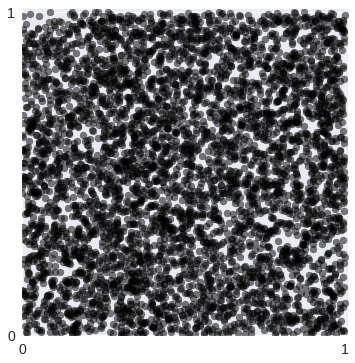

In [31]:
fig, ax = plt.subplots()
ax.set_aspect('equal');

ax.scatter(x, y, c='k', alpha=0.5);

ax.set_xticks([0, 1]);
ax.set_xlim(0, 1.01);

ax.set_yticks([0, 1]);
ax.set_ylim(0, 1.01);

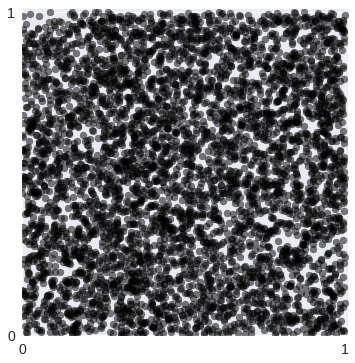

In [32]:
fig

In [33]:
in_circle = x**2 + y**2 <= 1

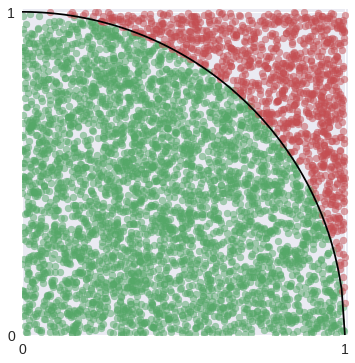

In [34]:
fig, ax = plt.subplots()
ax.set_aspect('equal');

x_plot = np.linspace(0, 1, 100)
ax.plot(x_plot, np.sqrt(1 - x_plot**2), c='k');

ax.scatter(x[in_circle], y[in_circle], c=green, alpha=0.5);
ax.scatter(x[~in_circle], y[~in_circle], c=red, alpha=0.5);

ax.set_xticks([0, 1]);
ax.set_xlim(0, 1.01);

ax.set_yticks([0, 1]);
ax.set_ylim(0, 1.01);

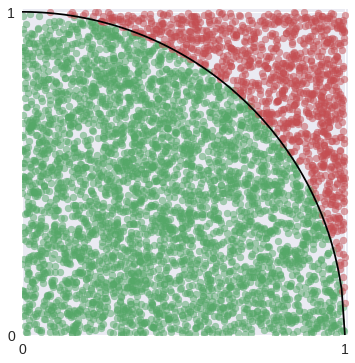

In [35]:
fig

In [36]:
4 * in_circle.mean()

3.1215999999999999

#### History of Monte Carlo Methods

<center><img src="http://www.bgu.ac.il/~oaharon/feynman/Feynman_Portraits_files/Ulam_Feynman_von_Neumann.jpg"></center>

## The Monty Hall Paradox

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/640px-Monty_open_door.svg.png'></center>

Initially, we have no information about which door the prize is behind.

In [16]:
with pm.Model() as monty_model:
    prize = pm.DiscreteUniform('prize', 0, 2)

If we choose door one:

<table>
    <tr>
        <td></td>
        <th colspan="3"><center>Monty can open</center></th>
    </tr>
    <tr>
        <th>Prize behind</th>
        <td>Door 1</td>
        <td>Door 2</td>
        <td>Door 3</td>
    </tr>
    <tr>
        <td>Door 1</td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td>Door 2</td>
        <td><font color="red">No</font></td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td>Door 2</td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="red">No</font></td>
    </tr>
</table>

In [17]:
from theano import tensor as tt

with monty_model:
    p_open = pm.Deterministic('p_open',
                              tt.switch(tt.eq(prize, 0),
                                        # it is behind the first door
                                        np.array([0., 0.5, 0.5]),
                              tt.switch(tt.eq(prize, 1),
                                        # it is behind the second door
                                        np.array([0., 0., 1.]),
                                        # it is behind the third door
                                        np.array([0., 1., 0.]))))

Monty opened the third door, revealing a goat.

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/640px-Monty_open_door.svg.png'></center>

In [18]:
with monty_model:
    opened = pm.Categorical('opened', p_open, observed=2)

Should we switch our choice of door?

In [19]:
with monty_model:
    monty_trace = pm.sample(random_seed=SEED)
    
monty_df = pm.trace_to_dataframe(monty_trace)

Assigned Metropolis to prize
100%|██████████| 1000/1000 [00:00<00:00, 4348.52it/s]


In [20]:
monty_df.prize.head()

0    0
1    0
2    0
3    0
4    1
Name: prize, dtype: int64

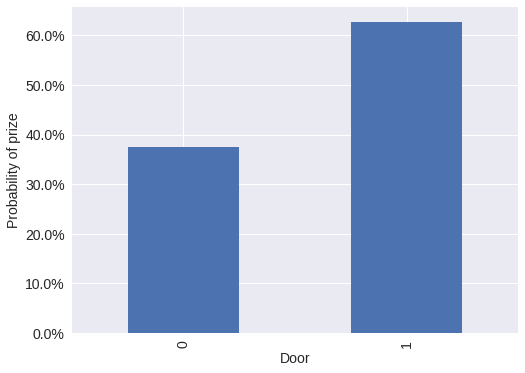

In [21]:
ax = (monty_df.groupby('prize')
              .size()
              .div(monty_df.shape[0])
              .plot(kind='bar'))

ax.set_xlabel("Door");
ax.yaxis.set_major_formatter(pct_formatter);
ax.set_ylabel("Probability of prize");

## Introduction to PyMC3

<center><img src='https://raw.githubusercontent.com/pymc-devs/pymc3/master/docs/pymc3_logo.jpg'></center>

From the [PyMC3 documentation](http://pymc-devs.github.io/pymc3/):

> PyMC3 is a Python package for Bayesian statistical modeling and Probabilistic Machine Learning which focuses on advanced Markov chain Monte Carlo and variational fitting algorithms. Its flexibility and extensibility make it applicable to a large suite of problems.

[![License](https://img.shields.io/badge/License-Apache%202.0-blue.svg)](https://opensource.org/licenses/Apache-2.0)

<center><img src="https://numfocus.wpengine.com/wp-content/uploads/2017/03/1457562110.png"></center>

As of October 2016, PyMC3 is a [NumFOCUS fiscally sponsored project](https://www.numfocus.org/blog/numfocus-announces-new-fiscally-sponsored-project-pymc3/).

### Features

* Uses [Theano](http://deeplearning.net/software/theano/) as a computational backend
    * Automated differentiation, dynamic C compilation, GPU integration
* Implements Hamiltonian Monte Carlo and [No-U-Turn sampling](https://arxiv.org/abs/1111.4246)
* High-level GLM (`R`-like syntax) and Gaussian process specification

### Contributing

<center><img src="https://pbs.twimg.com/media/C_FgWkLV0AAYDBO.jpg" width="500"></center>

<center>[Discourse](https://discourse.pymc.io/)</center>
[![Gitter chat](https://badges.gitter.im/gitterHQ/gitter.png)](https://gitter.im/pymc-devs/pymc?utm_source=badge&utm_medium=badge&utm_campaign=pr-badge&utm_content=badge)

## Hamiltonian Monte Carlo in PyMC3

In [24]:
x_ani = np.linspace(0, 1, 100)
y_ani = 1 - 2 * x_ani + np.random.normal(0., 0.25, size=100)

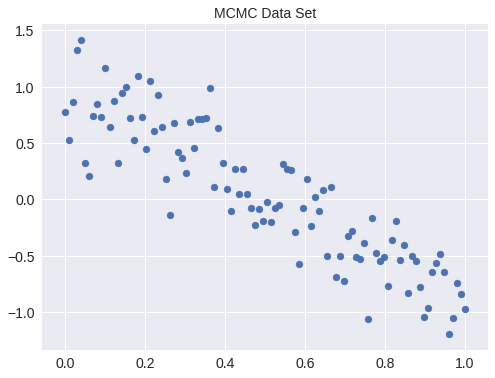

In [25]:
fig, ax = plt.subplots()

ax.scatter(x_ani, y_ani, c=blue);

ax.set_title('MCMC Data Set');

In [26]:
with pm.Model() as mcmc_model:
    β0 = pm.Normal('β0', 0., 10.)
    β = pm.Normal('β', 0., 10.)
    
    σ = pm.HalfCauchy('σ', 5.)
    y_obs = pm.Normal('y_obs', β0 + β * x_ani, σ, observed=y_ani)
    
    mcmc_trace = pm.sample(draws=100, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 95%|█████████▌| 571/600 [00:01<00:00, 559.64it/s]/opt/conda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:429: UserWarning: Chain 0 contains only 100 samples.
  % (self._chain_id, n))
/opt/conda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.887068706221, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 600/600 [00:01<00:00, 516.45it/s]


In [27]:
mcmc_cov = np.cov(mcmc_trace['β0'], mcmc_trace['β'])

mcmc_sigma, mcmc_U = np.linalg.eig(mcmc_cov)
mcmc_angle = 180. / np.pi * np.arccos(np.abs(mcmc_U[0, 0]))

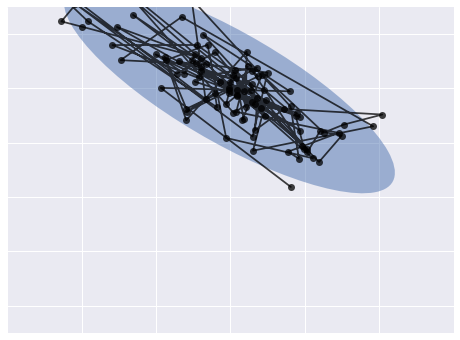

In [28]:
mcmc_fig, mcmc_ax = plt.subplots()

e = Ellipse((mcmc_trace['β0'].mean(), mcmc_trace['β'].mean()),
            2 * np.sqrt(5.991 * mcmc_sigma[0]), 2 * np.sqrt(5.991 * mcmc_sigma[1]),
            angle=mcmc_angle, zorder=5)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(1)

mcmc_ax.plot(mcmc_trace['β0'], mcmc_trace['β'],
             '-o', c='k', alpha=0.75);

mcmc_ax.add_artist(e);

mcmc_ax.set_xticklabels([]);
mcmc_ax.set_xlim(0.85, 1.15);

mcmc_ax.set_yticklabels([]);
mcmc_ax.set_ylim(-2.35, -1.75);

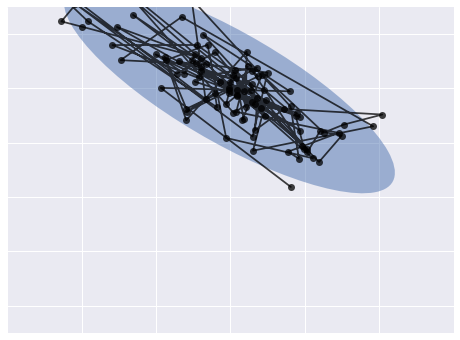

In [29]:
mcmc_fig

### The Curse of Dimensionality

In [37]:
def sphere_volume(d):
    return 2. * np.power(np.pi, d / 2.) / d / sp.special.gamma(d / 2)

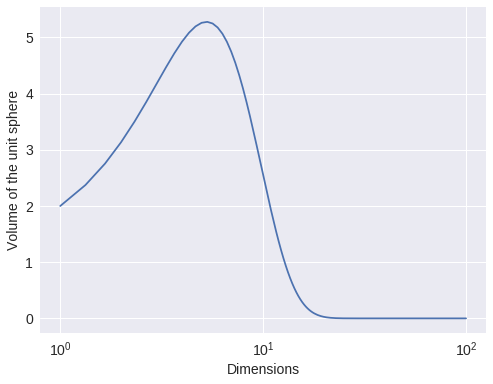

In [38]:
fig, ax = plt.subplots()

d_plot = np.linspace(1, 100, 300)

ax.plot(d_plot, sphere_volume(d_plot));

ax.set_xscale('log');
ax.set_xlabel("Dimensions");

ax.set_ylabel("Volume of the unit sphere");

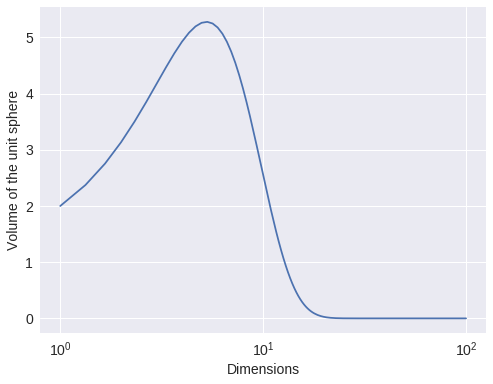

In [39]:
fig

### Hamiltonian Monte Carlo

<center><img src="https://upload.wikimedia.org/wikipedia/commons/6/61/Gaussian_curvature.svg" width="500"></center>

<center><img src="http://www.deeplearning.net/software/theano/_static/theano_logo.png"></center>

$$\frac{d}{dx} \left(x^3\right) = 3 x^2$$

In [22]:
x = tt.dscalar('x')
x.tag.test_value = 0.

y = x**3

In [23]:
from theano import pprint

pprint(tt.grad(y, x))

'((fill((x ** TensorConstant{3}), TensorConstant{1.0}) * TensorConstant{3}) * (x ** (TensorConstant{3} - TensorConstant{1})))'

### Case Study: 1984 Congressional Votes

In [40]:
%%bash
export DATA_URI='https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'

if [[ ! -e /tmp/house-votes-84.data ]]
then
    wget -O /tmp/house-votes-84.data $DATA_URI
fi

In [41]:
N_BILL = 16
BILL_COLS = list(range(N_BILL))


vote_df = (pd.read_csv('/tmp/house-votes-84.data',
                      names=['party'] + BILL_COLS)
            .rename_axis('rep_id', axis=0)
            .reset_index())

In [42]:
vote_df.head()

,rep_id,party,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [43]:
n_rep, _ = vote_df.shape

In [44]:
vote_df['party_id'], party_map = vote_df.party.factorize()

long_df = (pd.melt(vote_df, id_vars=['rep_id', 'party_id'], value_vars=BILL_COLS,
                   var_name='bill_id', value_name='vote_raw')
             .assign(bill_id=lambda df: df.bill_id.astype(np.int64),
                     vote=lambda df: np.where(df.vote_raw == 'y', 1,
                                              np.where(df.vote_raw == 'n', 0, np.nan)))
             .dropna()
             .drop('vote_raw', axis=1))

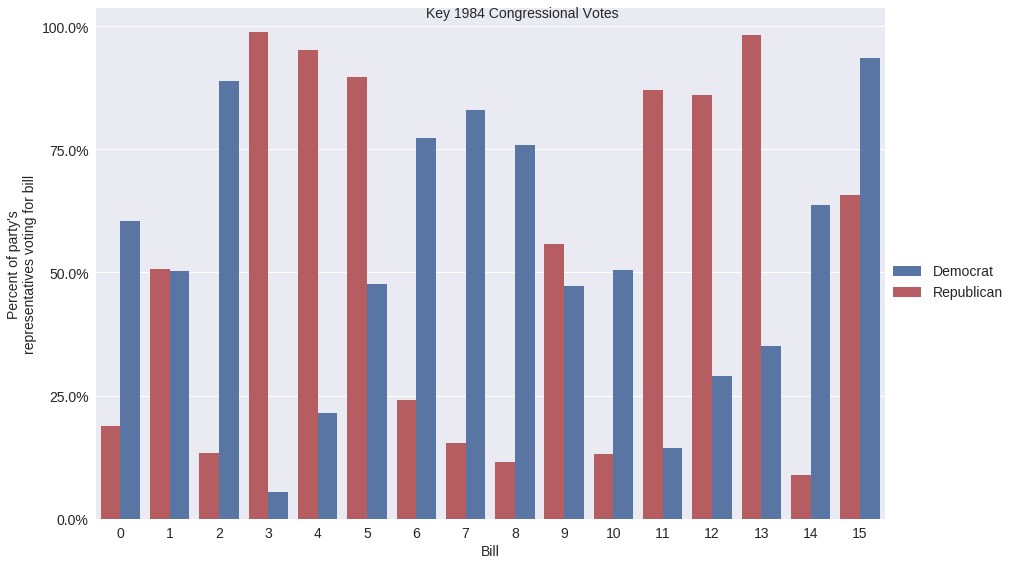

In [45]:
grid = sns.factorplot('bill_id', 'vote', 'party_id', long_df,
                      kind='bar', ci=None, size=8, aspect=1.5, legend=False,
                      palette=[red, blue]);

ax = grid.axes[0, 0]
ax.set_yticks(np.linspace(0, 1, 5));
ax.yaxis.set_major_formatter(pct_formatter);

grid.set_axis_labels('Bill', 'Percent of party\'s\nrepresentatives voting for bill');
grid.add_legend(legend_data={party_map[int(key)].capitalize(): artist
                             for key, artist in grid._legend_data.items()});
grid.fig.suptitle('Key 1984 Congressional Votes');

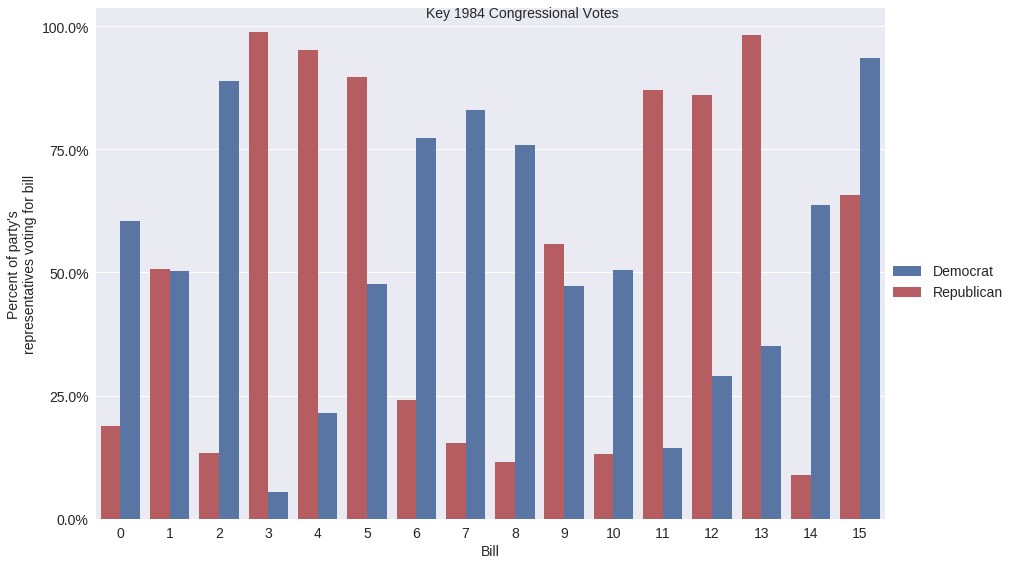

In [46]:
grid.fig

**Latent State Model**

* Representatives ($\color{blue}{\theta_i}$) and bill ($\color{green}{b_j})$ have _ideal points_ on a liberal-conservative spectrum
    * If the ideal points are equal, there is a 50% chance the representative will vote for the bill

In [47]:
def hierarchical_normal(name, shape):
    μ = pm.Normal('μ_{}'.format(name), 0., 1.)
    Δ = pm.Normal('Δ_{}'.format(name), 0., 1., shape=shape)
    σ = pm.Normal('σ_{}'.format(name), 5.)
    
    return pm.Deterministic(name, μ + Δ * σ)

In [48]:
rep_id = long_df.rep_id.values
bill_id = long_df.bill_id.values

vote = long_df.vote.values

In [49]:
with pm.Model() as vote_model:
    # representative ideal points
    θ = pm.Normal('θ', 0., 1., shape=n_rep)
    
    # bill ideal points
    a = hierarchical_normal('a', N_BILL)

In [50]:
with vote_model:
    θ_pot = pm.Potential('θ_pot', tt.switch(θ[1] < 0., -np.inf, 0.))

* Bills also have an ability to _discriminate_ ($\color{red}{a_j}$) between conservative and liberal representatives
    * Some bills have broad bipartisan support, while some provoke votes along party lines

In [51]:
with vote_model:
    # bill discrimination parameters
    b = hierarchical_normal('b', N_BILL)

This model has

In [76]:
n_rep + 2 * (N_BILL + 1)

469

parameters

**Observation Model**

$$
\begin{align*}
P(\textrm{Representative }i \textrm{ votes for bill }j\ |\ \color{blue}{\theta_i}, \color{green}{b_j}, \color{red}{a_j})
    & = \frac{1}{1 + \exp\left(-\left(\color{red}{a_j} \cdot \color{blue}{\theta_i} - \color{green}{b_j}\right)\right)}
\end{align*}
$$

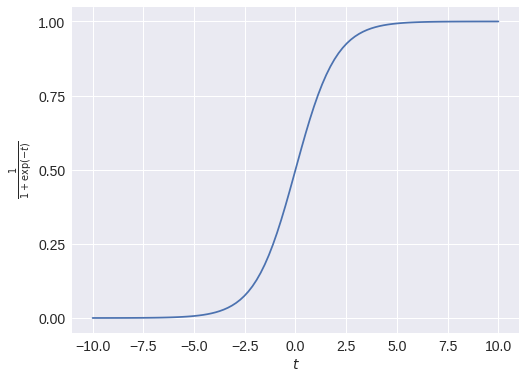

In [52]:
fig, ax = plt.subplots()

t_plot = np.linspace(-10, 10, 100)
ax.plot(t_plot, sp.special.expit(t_plot));

ax.set_xlabel("$t$");

ax.set_yticks(np.linspace(0, 1, 5));
ax.set_ylabel(r"$\frac{1}{1 + \exp(-t)}$");

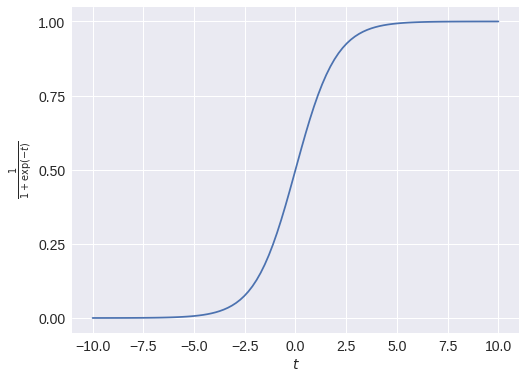

In [53]:
fig

$$
\begin{align*}
P(\textrm{Representative }i \textrm{ votes for bill }j\ |\ \color{blue}{\theta_i}, \color{green}{b_j}, \color{red}{a_j})
    & = \frac{1}{1 + \exp\left(-\color{red}{a_j} \cdot \color{blue}{\theta_i} - \color{green}{b_j}\right)}
\end{align*}
$$

In [54]:
with vote_model:
    η = a[bill_id] * θ[rep_id] - b[bill_id]
    p = pm.math.sigmoid(η)
    
    obs = pm.Bernoulli('obs', p, observed=vote)

**Hamiltonian Monte Carlo Inference**

In [55]:
N_JOBS = 3
JOB_SEEDS = [SEED + i for i in range(N_JOBS)]

with vote_model:
    nuts_trace = pm.sample(init='adapt_diag', njobs=N_JOBS, random_seed=JOB_SEEDS)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
100%|██████████| 1000/1000 [01:36<00:00, 12.37it/s]


### Convergence Diagnostics

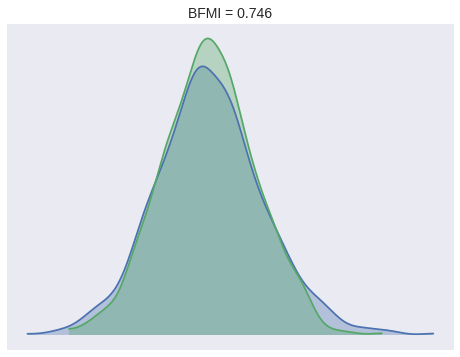

In [80]:
ax = pm.energyplot(nuts_trace, legend=False)
ax.set_title("BFMI = {:.3f}".format(pm.bfmi(nuts_trace)));

In [58]:
max(np.max(gr_values) for gr_values in pm.gelman_rubin(nuts_trace).values())

1.0208206809244023

### Ideal Points

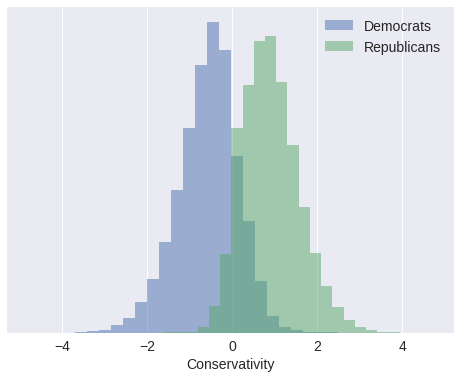

In [59]:
fig, ax = plt.subplots()

dem_ids = vote_df[vote_df.party == 'democrat'].rep_id.values
rep_ids = vote_df[vote_df.party == 'republican'].rep_id.values

ax.hist(nuts_trace['θ'][:, dem_ids].ravel(),
        bins=30, normed=True, alpha=0.5,
        label='Democrats');
ax.hist(nuts_trace['θ'][:, rep_ids].ravel(),
        bins=30, normed=True, alpha=0.5,
        label='Republicans');

ax.set_xlabel("Conservativity");

ax.set_yticks([]);

ax.legend();

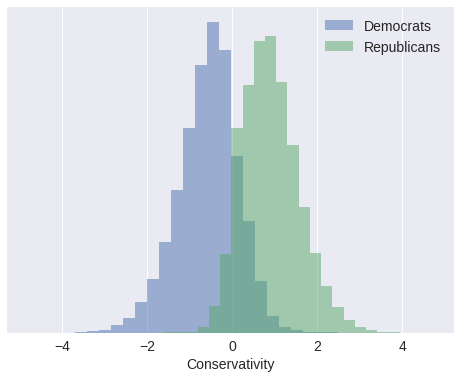

In [60]:
fig

### Discriminative Ability of Bills

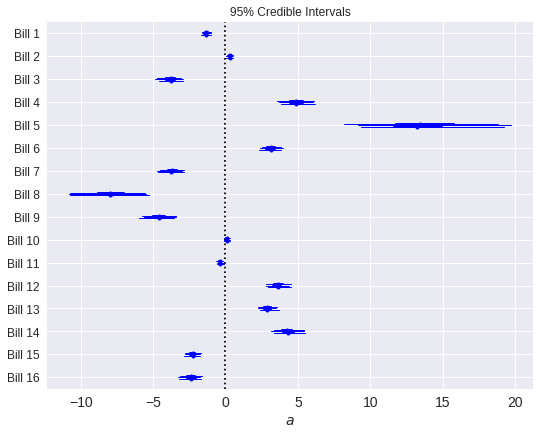

In [86]:
pm.forestplot(nuts_trace, varnames=['a'], rhat=False, xtitle="$a$",
              ylabels=["Bill {}".format(i + 1) for i in range(N_BILL)]);

### Comparison to basic MCMC

In [63]:
with vote_model:
    step = pm.Metropolis()
    met_trace_ = pm.sample(10000, step, njobs=N_JOBS, random_seed=JOB_SEEDS)
    
met_trace = met_trace_[5000::5]

100%|██████████| 10500/10500 [02:26<00:00, 71.45it/s]


In [64]:
max(np.max(gr_values) for gr_values in pm.gelman_rubin(met_trace).values())

39.87901257961822

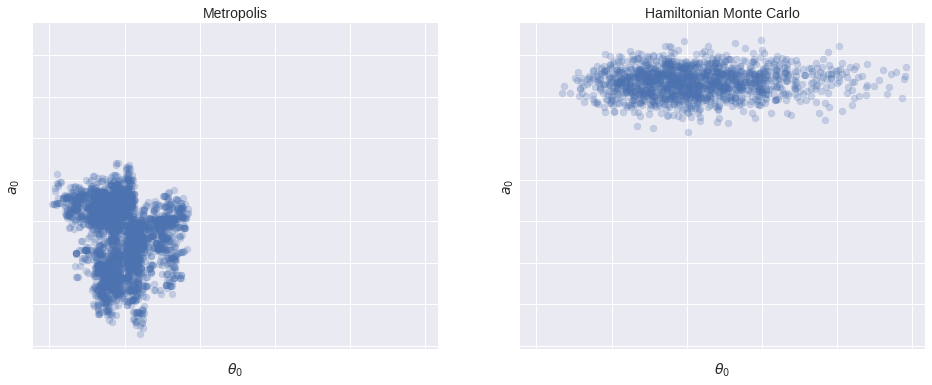

In [65]:
fig, (met_ax, nuts_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 6))

met_ax.scatter(met_trace['θ'][:, 0], met_trace['a'][:, 0],
               alpha=0.25);

met_ax.set_xticklabels([]);
met_ax.set_xlabel(r"$θ_0$");

met_ax.set_yticklabels([]);
met_ax.set_ylabel("$a_0$");

met_ax.set_title("Metropolis");

nuts_ax.scatter(nuts_trace['θ'][:, 0], nuts_trace['a'][:, 0],
                alpha=0.25);

nuts_ax.set_xlabel(r"$θ_0$");
nuts_ax.set_ylabel("$a_0$");
nuts_ax.set_title("Hamiltonian Monte Carlo");

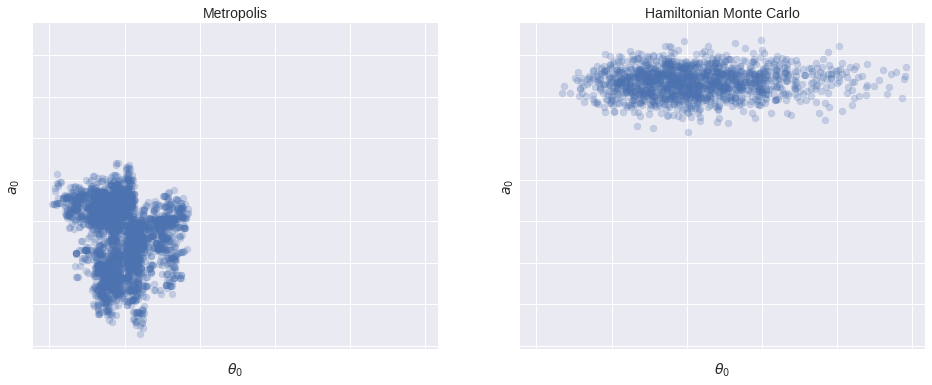

In [66]:
fig

In [88]:
%%bash
jupyter nbconvert \
    --to=slides \
    --reveal-prefix=https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.2.0/ \
    --output=os-bayes-pymc3-fosscon-2017 \
    ./Open\ Source\ Bayesian\ Inference\ in\ Python\ with\ PyMC3.ipynb

[NbConvertApp] Converting notebook ./Open Source Bayesian Inference in Python with PyMC3.ipynb to slides
[NbConvertApp] Writing 1191552 bytes to ./os-bayes-pymc3-fosscon-2017.slides.html
